In [17]:
import os
import sys
import mne
from facet.facet import facet
from loguru import logger
import matplotlib.pyplot as plt
import numpy as np
sys.path.append("../../src")
from facet.Epilepsy.template_utils import  extract_spike_windows
from facet.Epilepsy.correlation_utils import  compute_spike_regressors
from facet.Epilepsy.shared_utils import build_template
from scipy.io import loadmat

os.getcwd()
os.chdir(os.path.dirname(os.path.abspath("__file__")))
logger.remove()
logger.add(sys.stderr, level="INFO")
logger.add("facet.log", level="DEBUG")

f = facet()

▶ Before filtering: max ≈ 3488.3 µV, min ≈ -1732.4 µV
▶ After filtering:  max ≈ 1004.4 µV, min ≈ -985.5 µV


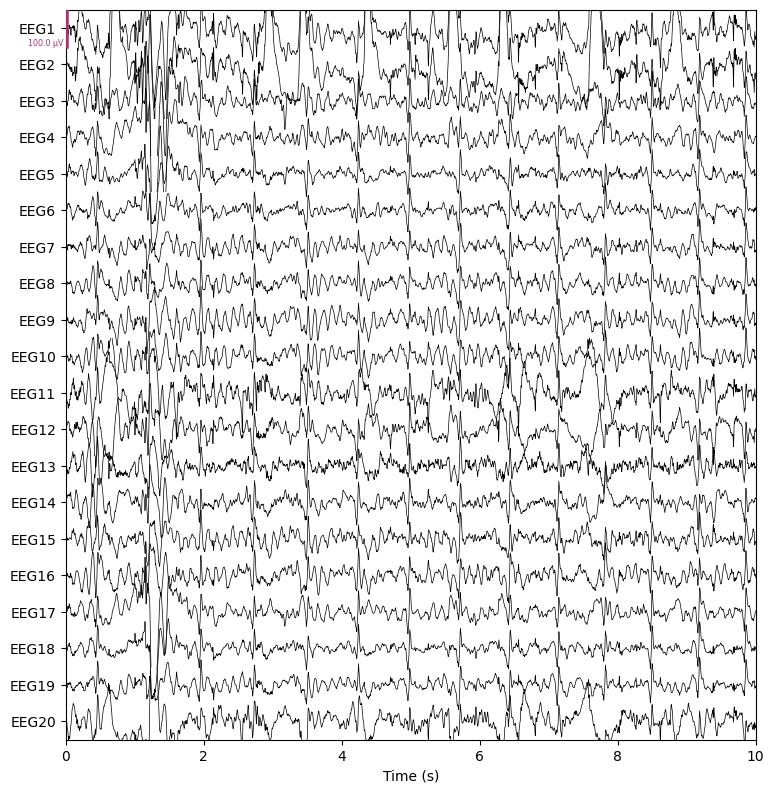

In [27]:


# 1) Load the .mat file
path = r"G:\Medical Engineering and Analytics\Project\FACETpy\examples\datasets\MAT_Files\DA00100W.mat"

mat = loadmat(path)
eeg = mat['eeg_data']  # shape (n_ch, n_samples), raw numbers   

sfreq   = 500.0  # Hz
ch_names = [f"EEG{i+1}" for i in range(eeg.shape[0])]
info     = mne.create_info(ch_names, sfreq, ch_types="eeg")
raw      = mne.io.RawArray(eeg, info)
raw.set_eeg_reference('average', projection=False)  

before_max_uv = raw.get_data().max() * 1e6
before_min_uv = raw.get_data().min() * 1e6
print(f"▶ Before filtering: max ≈ {before_max_uv:.1f} µV, min ≈ {before_min_uv:.1f} µV")

# 4) Notch + band-pass 
raw.notch_filter([50, 100], picks="eeg", verbose=False)
raw.filter(2.0, 70.0, picks="eeg", verbose=False)   


after_max_uv = raw.get_data().max() * 1e6
after_min_uv = raw.get_data().min() * 1e6
print(f"▶ After filtering:  max ≈ {after_max_uv:.1f} µV, min ≈ {after_min_uv:.1f} µV")

scalings = {"eeg": 50e-6}
raw.plot(duration=10, scalings=scalings, show_scrollbars=False)
plt.close("all")




### PRINT annotation times

In [28]:

events = mat['events']
for row in events:
    time_str, _, label = row
    print("Label:", label, "at time (s):", float(time_str))


Label: Waking                           at time (s): 0.584
Label: !                                at time (s): 1.256
Label: !start                           at time (s): 150.548
Label: !end                             at time (s): 151.848
Label: !start                           at time (s): 212.492
Label: !end                             at time (s): 214.338
Label: !                                at time (s): 302.076
Label: !                                at time (s): 379.05
Label: !                                at time (s): 388.546
Label: !                                at time (s): 408.716
Label: !                                at time (s): 421.13
Label: !                                at time (s): 445.35
Label: !                                at time (s): 575.632
Label: !                                at time (s): 620.446
Label: !                                at time (s): 745.29
Label: !                                at time (s): 794.594
Label: !                        

### MANUALLY SLICE SPIKE WINDOW

found 21 spikes


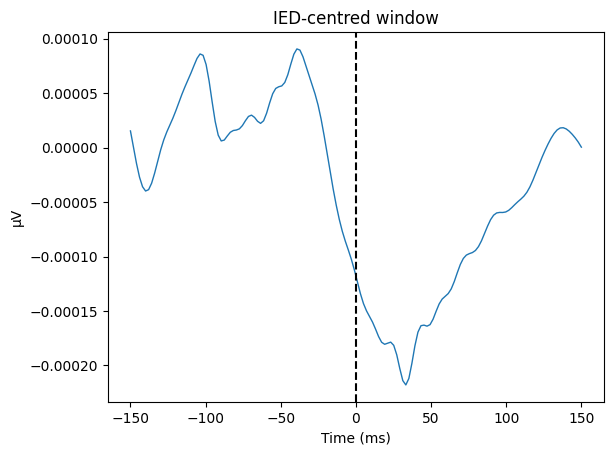

segments.shape = (21, 150)


In [29]:

chan_idx   = 0      # channel you want
half_win_s = 0.15   # 100 ms before & after the spike

# grab the spike times (seconds) 
events = mat["events"]
spike_sec = [float(r[0]) for r in events if r[2].strip() == "!"]
print(f"found {len(spike_sec)} spikes")

# extract windows
segments, times = extract_spike_windows(raw, spike_sec, chan_idx, half_win_s)
print("segments.shape =", segments.shape)


### BUILD TEMPLATE

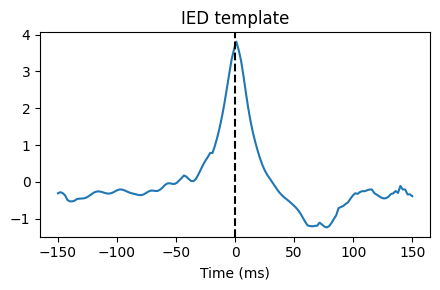

In [25]:

best_ch, template_z, half_shift = build_template(raw, spike_sec, half_win_s=0.15)

### CORRELATION ICA

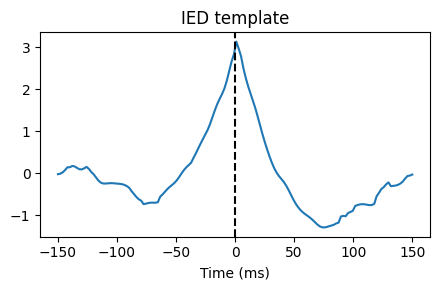

r_ica max = 0.952   th_ica = 0.714
Caught 10/21 spikes within ±0.1s


In [30]:

# run  existing pipeline *unchanged*, with th_ica=0.85:
template_z, r_raw, r_ica, peaks_raw, peaks_ica, best_ch, best_ica_idx, caught, missed = \
    compute_spike_regressors(raw, spike_sec,
                             half_win_s=0.15,
                             th_raw=0.35, 
                             match_tol_s=0.1)
